# 1. Regression Algorithms: Theory, Math, and Implementation

Regression is a supervised learning technique used to predict continuous numerical values based on input features. In this notebook, we will explore five fundamental regression algorithms, understand their mathematical foundations, and visualize their decision boundaries using Python and `scikit-learn`.

---
### Setup & Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from ipywidgets import interact, IntSlider, FloatSlider

# Global plot settings
plt.style.use('seaborn-v0_8-darkgrid')

# Generate a shared complex dataset for SVR, Tree, and Forest
np.random.seed(42)
X_complex = np.sort(5 * np.random.rand(100, 1), axis=0)
y_complex = np.sin(X_complex).ravel()
y_complex[::5] += 3 * (0.5 - np.random.rand(20)) # Add noise

### 1. Linear Regression
Linear Regression assumes a linear relationship between the input variables ($X$) and the single output variable ($y$). It tries to find the "line of best fit" that minimizes the error between the predicted and actual values.

The hypothesis function for a simple linear regression is:
$$y = \beta_0 + \beta_1 x + \epsilon$$

Where:
* $y$ is the predicted output.
* $\beta_0$ is the y-intercept.
* $\beta_1$ is the slope (coefficient).
* $\epsilon$ is the error term.

The model learns by minimizing the **Mean Squared Error (MSE)** Cost Function ($J$):
$$J(\beta_0, \beta_1) = \frac{1}{2n} \sum_{i=1}^{n} (y_i - (\beta_0 + \beta_1 x_i))^2$$

While it doesn't have complex hyperparameters like depth or penalty, we can visualize how it reacts to different levels of noise in the data.

In [2]:
@interact(noise=FloatSlider(min=0.0, max=5.0, step=0.5, value=1.0))
def plot_linear_regression(noise):
    np.random.seed(42)
    X = 2 * np.random.rand(100, 1)
    y = 4 + 3 * X + np.random.randn(100, 1) * noise
    
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    
    X_new = np.array([[0], [2]])
    y_predict = lin_reg.predict(X_new)
    
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, color="blue", alpha=0.6, label="Training data")
    plt.plot(X_new, y_predict, "r-", linewidth=2, label=f"Fit: y = {lin_reg.intercept_[0]:.2f} + {lin_reg.coef_[0][0]:.2f}x")
    plt.title(f"Linear Regression (Noise level: {noise})")
    plt.ylim(0, 15)
    plt.legend(loc="upper left")
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='noise', max=5.0, step=0.5), Output()), _dom_classes=…

### 2. Polynomial Regression
When the data shows a non-linear relationship, fitting a straight line will result in underfitting. Polynomial Regression solves this by adding powers of the original features as new features, allowing the model to fit a curve.

We extend the linear equation to a polynomial of degree $d$:
$$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \dots + \beta_d x^d + \epsilon$$

Under the hood, this is still a *linear* model because the coefficients ($\beta$) are linear, even though the features ($x^2, x^3$) are not.

Use the slider to increase the `degree`. Notice how a low degree *underfits* the curve, while a very high degree *overfits* by trying to connect every single noisy point.

the `degree` represents the highest power of the independent variable ($x$) in the regression equation. It essentially dictates the "flexibility" or the number of curves (bends) the model can use to fit the data.

* **Degree 1:** This is a standard Linear Regression ($y = \beta_1x + \beta_0$). It is a straight line with zero bends
* **Degree 2:** A Quadratic equation ($y = \beta_2x^2 + \beta_1x + \beta_0$). It creates a single curve (a parabola), forming a "U" or "n" shape.
* **Degree 3:** A Cubic equation ($y = \beta_3x^3 + \beta_2x^2 + \beta_1x + \beta_0$). It can have up to two bends, creating an "S" shape.
* **High Degree (e.g., 10+):** The line becomes extremely "wiggly," allowing it to pass through almost every data point.

In [12]:
@interact(degree=IntSlider(min=1, max=15, step=1, value=2))
def plot_polynomial_regression(degree):
    np.random.seed(42)
    m = 100
    X = 6 * np.random.rand(m, 1) - 3
    y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
    
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, y)
    
    X_new = np.linspace(-3, 3, 100).reshape(100, 1)
    y_new = lin_reg.predict(poly_features.transform(X_new))
    
    plt.figure(figsize=(8, 5))
    plt.scatter(X, y, color="blue", alpha=0.6, label="Data")
    plt.plot(X_new, y_new, "r-", linewidth=2, label=f"Degree {degree} fit")
    plt.title("Polynomial Regression")
    plt.ylim(-2, 10)
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=2, description='degree', max=15, min=1), Output()), _dom_classes=('widge…

### 3. Support Vector Regression (SVR)
Unlike Linear Regression which tries to minimize the error, SVR tries to fit the error *within a certain threshold* (called the $\epsilon$-tube). It only cares about the points that fall outside this tube (the support vectors).

The goal is to find a function $f(x) = \langle w, x \rangle + b$ that is as "flat" as possible (minimizing the norm of $w$) while keeping the prediction errors within a margin $\epsilon$:

$$\text{Minimize: } \frac{1}{2} ||w||^2$$
$$\text{Subject to: } |y_i - (\langle w, x_i \rangle + b)| \le \epsilon$$

By using the "Kernel Trick" (like the Radial Basis Function or RBF), SVR can efficiently map data into higher dimensions to solve highly non-linear problems.

**C:** The penalty parameter. A high `C` strictly forces the model to fit the data (potentially overfitting), while a low `C` allows a smoother curve.

**Epsilon ($\epsilon$):** The width of the tube where no penalty is given to errors.

In [4]:
@interact(C=FloatSlider(min=0.1, max=1000, step=10, value=100),
          epsilon=FloatSlider(min=0.01, max=1.0, step=0.05, value=0.1))
def plot_svr(C, epsilon):
    svr_rbf = SVR(kernel='rbf', C=C, gamma=0.1, epsilon=epsilon)
    svr_rbf.fit(X_complex, y_complex)
    
    X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    y_pred = svr_rbf.predict(X_test)
    
    plt.figure(figsize=(8, 5))
    plt.scatter(X_complex, y_complex, color="darkorange", label="data")
    plt.plot(X_test, y_pred, color="navy", lw=2, label="SVR RBF")
    plt.title(f"Support Vector Regression (C={C}, epsilon={epsilon:.2f})")
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=100.0, description='C', max=1000.0, min=0.1, step=10.0), FloatSlider(v…

In [11]:
# Generate synthetic data
np.random.seed(42)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.2, 40)

@interact(C=FloatSlider(min=0.1, max=100, step=1, value=10),
          epsilon=FloatSlider(min=0.01, max=0.5, step=0.05, value=0.15))
def visualize_svr_slacks(C, epsilon):
    # Fit SVR Model
    svr = SVR(kernel='rbf', C=C, epsilon=epsilon, gamma=0.5)
    svr.fit(X, y)
    
    # Generate points for the smooth line
    X_plot = np.linspace(0, 5, 100).reshape(-1, 1)
    y_pred_plot = svr.predict(X_plot)
    
    # Predict on training points to find slacks
    y_pred_train = svr.predict(X)
    
    plt.figure(figsize=(10, 6))
    
    # 1. Plot the epsilon tube
    plt.fill_between(X_plot.ravel(), y_pred_plot - epsilon, y_pred_plot + epsilon, 
                     color='gray', alpha=0.2, label=f'ε-tube (ε={epsilon})')
    
    # 2. Plot the Regression Line
    plt.plot(X_plot, y_pred_plot, color='red', lw=2, label='SVR Prediction')
    
    # 3. Plot Data Points
    plt.scatter(X, y, color='black', s=30, zorder=3, label='Data Points')

    # 4. Draw Slack Variables (ξ)
    # Slack exists only if |y - y_pred| > epsilon
    for i in range(len(X)):
        error = y[i] - y_pred_train[i]
        if abs(error) > epsilon:
            # Determine if point is above or below the tube
            boundary = y_pred_train[i] + epsilon if error > 0 else y_pred_train[i] - epsilon
            # Draw a dashed line representing the slack variable ξ
            plt.vlines(X[i], boundary, y[i], colors='blue', linestyles='dashed', alpha=0.7)

    plt.title(f"SVR Slacks: Points outside the tube are penalized (C={C})")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=10.0, description='C', min=0.1, step=1.0), FloatSlider(value=0.15, des…

**How the "Trick" Works.**
 
 Instead of trying to force a line in 2D, the Kernel Trick mathematically "lifts" the data into a 3D space. In this new dimension (e.g., adding a $z$-axis calculated as $z = x^2 + y^2$), you can easily pass a flat plane (hyperplane) between the two groups.The "Trick" part is that we don't actually calculate the new coordinates for every data point. Calculating $x^2, y^2, xy \dots$ for millions of points in high dimensions is computationally "expensive" and slow.Instead, the Kernel Trick uses a Kernel Function, which calculates the dot product (similarity) between two points as if they were in that higher dimension.*

**Common Kernel Functions**
Different kernels are used depending on the shape of your data:
* **Linear Kernel:** No transformation; used for data that is already linearly separable.
  * Formula: $K(x_i, x_j) = x_i^T x_j$
* **Polynomial Kernel:** Maps data into a polynomial space. Useful for curved boundaries.
  * Formula: $K(x, y) = (x^T y + c)^d$
* **Radial Basis Function (RBF/Gaussian):** The most popular. It can theoretically map data into an infinite-dimensional space. It creates "islands" or circular boundaries around data points.
  * Formula: $K(x, y) = \exp(-\gamma ||x - y||^2)$

The Dual Formulation of the SVR optimization relies only on the dot products of the input vectors. We replace the dot product $\langle x_i, x_j \rangle$ with the Kernel:$$f(x) = \sum_{i=1}^{n} (\alpha_i - \alpha_i^*) K(x_i, x) + b$$


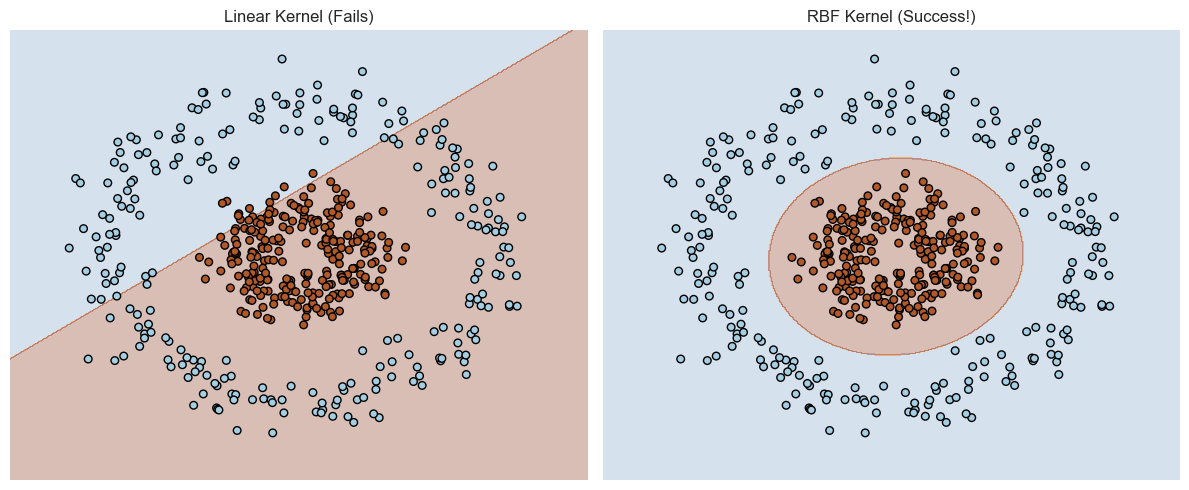

In [10]:
from sklearn.datasets import make_circles
from sklearn.svm import SVC

# 1. Generate non-linearly separable data (Circles)
X, y = make_circles(n_samples=500, factor=0.3, noise=0.1, random_state=42)

# 2. Define models
# Linear Kernel (No trick)
linear_svm = SVC(kernel='linear')
linear_svm.fit(X, y)

# RBF Kernel (The Trick)
rbf_svm = SVC(kernel='rbf', gamma=0.7)
rbf_svm.fit(X, y)

# 3. Visualization logic
def plot_boundaries(model, X, y, title):
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 500), np.linspace(-1.5, 1.5, 500))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolor='k', cmap=plt.cm.Paired)
    plt.title(title)
    plt.xticks([]); plt.yticks([])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_boundaries(linear_svm, X, y, "Linear Kernel (Fails)")

plt.subplot(1, 2, 2)
plot_boundaries(rbf_svm, X, y, "RBF Kernel (Success!)")

plt.tight_layout()
plt.show()

*In the left plot, the Linear Kernel tries to draw a straight line. No matter where it puts that line, it will misclassify roughly 50% of the data because the "inner circle" is surrounded by the "outer ring".*

*The RBF kernel essentially maps these 2D points into a higher dimension. Imagine the inner circle being pushed "up" into a 3D peak while the outer ring stays "down" in a valley.*

*Now, a flat 2D plane (a hyperplane) can slice right through the mountain, separating the peak from the valley perfectly. When we project that slice back down to our 2D screen, it looks like a circular boundary.*

**Key Parameters:**

**Gamma ($\gamma$):** Controls how "tight" the kernel stays to individual points. High gamma creates very complex, wiggly boundaries (potential overfitting); low gamma creates smoother, broader boundaries.

**C:** Controls the trade-off between a smooth boundary and classifying training points correctly.

### 4. Decision Tree Regression
A Decision Tree breaks down a dataset into smaller and smaller subsets by asking a series of True/False questions. The final predictions are made at the "leaves" of the tree. It is highly interpretable but prone to overfitting.

The algorithm splits the data into two regions ($R_1$ and $R_2$) at a specific feature $j$ and threshold $s$. It searches for the split that minimizes the Mean Squared Error of the resulting regions:

$$J(j, s) = \min_{j, s} \left[ \min_{c_1} \sum_{x_i \in R_1(j,s)} (y_i - c_1)^2 + \min_{c_2} \sum_{x_i \in R_2(j,s)} (y_i - c_2)^2 \right]$$

Where $c_1$ and $c_2$ are the mean target values in regions $R_1$ and $R_2$.

Use the slider to increase `max_depth`. A depth of 1 or 2 is too simple, but if you push it to 10, watch how the model creates rigid, stepped jumps to perfectly hit the noise (classic overfitting).

In [7]:
@interact(max_depth=IntSlider(min=1, max=15, step=1, value=3))
def plot_decision_tree(max_depth):
    tree_reg = DecisionTreeRegressor(max_depth=max_depth)
    tree_reg.fit(X_complex, y_complex)
    
    X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    y_pred = tree_reg.predict(X_test)
    
    plt.figure(figsize=(8, 5))
    plt.scatter(X_complex, y_complex, s=20, edgecolor="black", c="darkorange", label="data")
    plt.plot(X_test, y_pred, color="cornflowerblue", label=f"Tree depth={max_depth}", linewidth=2)
    plt.title("Decision Tree Regression")
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=3, description='max_depth', max=15, min=1), Output()), _dom_classes=('wi…

### 5. Random Forest Regression
Random Forest is an ensemble method. Instead of relying on one Decision Tree, it builds multiple trees on random subsets of the data (Bagging) and averages their predictions. This significantly reduces the overfitting seen in single Decision Trees.

If a Random Forest contains $B$ decision trees, the final prediction $\hat{y}$ for an input $x$ is simply the average of the predictions from all individual trees ($f_b(x)$):

$$\hat{y} = \frac{1}{B} \sum_{b=1}^{B} f_b(x)$$

* **n_estimators:** The number of trees in the forest. Notice how adding more trees smooths out the harsh steps of a single decision tree.
* **max_depth:** How deep each individual tree can go

In [ ]:
@interact(n_estimators=IntSlider(min=1, max=200, step=10, value=10),
          max_depth=IntSlider(min=1, max=15, step=1, value=4))
def plot_random_forest(n_estimators, max_depth):
    rf_reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf_reg.fit(X_complex, y_complex)
    
    X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    y_pred = rf_reg.predict(X_test)
    
    plt.figure(figsize=(8, 5))
    plt.scatter(X_complex, y_complex, s=20, edgecolor="black", c="darkorange", label="data")
    plt.plot(X_test, y_pred, color="green", label=f"RF (Trees={n_estimators}, Depth={max_depth})", linewidth=2)
    plt.title("Random Forest Regression")
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=10, description='n_estimators', max=200, min=1, step=10), IntSlider(valu…